In [1]:
# change dir because notebook is in a child directory of the root directory (and does not find my modules)
import os 
try:
    os.chdir(r'/Users/joan/code/python/jokes-app')
except FileNotFoundError:
    os.chdir(r'/home/repos/joke-app')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import src.api.src.db.core as db
try:
    from src.api.src.db.secret import (
        HOST_OVH as HOST, 
        POSTGRES_USER, 
        POSTGRES_PASSWORD_OVH as POSTGRES_PASSWORD, 
        SCHEMA_NAME
    )
except ImportError:
    from src.api.src.db.secret import HOST, POSTGRES_USER, POSTGRES_PASSWORD, SCHEMA_NAME

### Get connection to Postgres DB

In [4]:
conn = db.connect(host=HOST, user=POSTGRES_USER, password=POSTGRES_PASSWORD, schema_name=SCHEMA_NAME)

### Get Number of subscribed users and unsubscribed users

In [5]:
df = db.execute_read(conn, "select * from users_mail")

In [6]:
n_subbed = df["deleted_at"].isna().sum()
n_unsubbed = len(df) - n_subbed

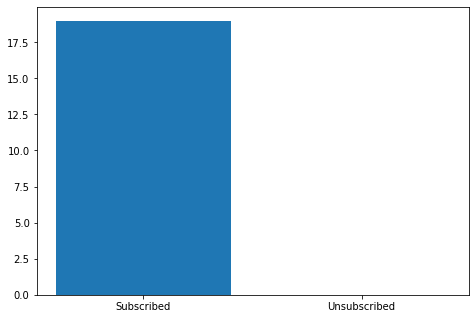

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
l_bars = ['Subscribed', 'Unsubscribed']
ax.bar(l_bars, [n_subbed, n_unsubbed])
plt.show()

### Top 10 Joke reviewers

In [8]:
df_mean_user = db.execute_read(conn, """
select 
	um.email, avg(r.rating), count(r)
from 
	ratings as r
left join users_mail as um
on (r.user_id = um.id_hash)
where "source" = 'mail' and um.email is not null
group by um.email
order by count(r.rating) desc
""")

In [19]:
df_mean_user.head(20)

,email,avg,count
0,watxaut@gmail.com,6.935484,31
1,jaime.conde@ficosa.com,1.900000,25
2,irene.chausse@mosaicfactor.com,5.357143,21
3,antoni.martinezlopez@ficosa.com,3.125000,20
4,Extern.javier.gris@seat.es,6.093750,16
5,adria.hr@gmail.com,3.750000,16
6,Javier.heras@volkswagen-groupservices.com,4.843750,16
7,guillem.mcid@gmail.com,6.333333,15
8,18mariaff@gmail.com,5.892857,14
9,alex.colomer.puig@gmail.com,3.269231,13


## TOP 5 Most Haters (min 5 reviews)

In [11]:
df_mean_user = df_mean_user[df_mean_user["count"] >= 5]
df_mean_user_hater = df_mean_user.sort_values(by=['avg', 'count'])
df_mean_user_hater.head(5)

,email,avg,count
1,jaime.conde@ficosa.com,1.900000,25
3,antoni.martinezlopez@ficosa.com,3.125000,20
9,alex.colomer.puig@gmail.com,3.269231,13
5,adria.hr@gmail.com,3.750000,16
6,Javier.heras@volkswagen-groupservices.com,4.843750,16


## TOP 5 Supporters (min 5 reviews)

In [20]:
df_mean_user_supporter = df_mean_user.sort_values(by=['avg', 'count'], ascending=False)
df_mean_user_supporter.head()

,email,avg,count
13,ingrid.falguera19@gmail.com,8.750000,8
11,neuscuadernpuig@gmail.com,8.636364,11
15,Miquel.regidor93@gmail.com,8.000000,5
10,bcocamarin@gmail.com,7.727273,11
0,watxaut@gmail.com,6.935484,31


## AVG joke rating per user

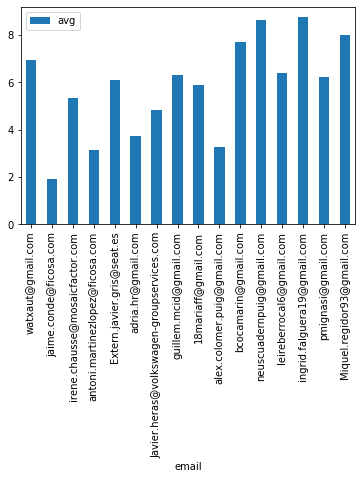

In [14]:
df_mean_user.head(20).plot.bar(x="email", y="avg")

### Rating Statistics

In [15]:
sql = """
select 
	sj.joke_id, r.rating, sj.created_at, r.created_at as voted_at
from
	sent_jokes as sj
left join 
	ratings as r
on 
	(r.joke_id = sj.joke_id)
where 
	r."source" = 'mail'
"""
df_ratings = db.execute_read(conn, sql)

#### Get last 10 ratings

In [16]:
df_ratings.tail(15)

,joke_id,rating,created_at,voted_at
225,1799,7.5,2019-11-26 08:30:28.428800,2019-11-26 07:59:38.580484
226,1799,10.0,2019-11-26 08:30:28.428800,2019-11-26 08:00:41.562224
227,1799,5.0,2019-11-26 08:30:28.428800,2019-11-26 08:12:55.719301
228,1799,10.0,2019-11-26 08:30:28.428800,2019-11-26 09:11:25.969538
229,1799,10.0,2019-11-26 08:30:28.428800,2019-11-26 14:19:59.180856
230,1800,7.5,2019-11-25 08:30:30.047762,2019-11-26 14:20:11.674667
231,1798,10.0,2019-11-22 08:30:29.013626,2019-11-26 14:20:29.850137
232,1801,7.5,2019-11-27 09:08:33.278919,2019-11-27 08:08:52.869278
233,1801,5.0,2019-11-27 09:08:33.278919,2019-11-27 08:09:20.854791
234,1801,5.0,2019-11-27 09:08:33.278919,2019-11-27 08:09:39.210540


## Get mean of ratings by joke and day

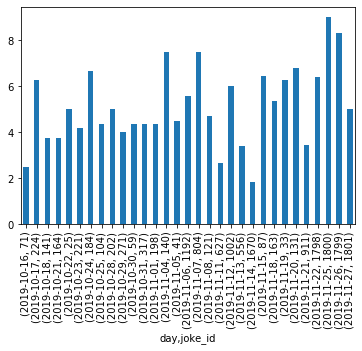

In [17]:
df_ratings["day"] = df_ratings["created_at"].dt.strftime('%Y-%m-%d')
df_ratings.groupby(["day", "joke_id"])["rating"].mean().plot.bar(x="day", y="rating")

## Get Std Deviation of ratings by joke and day

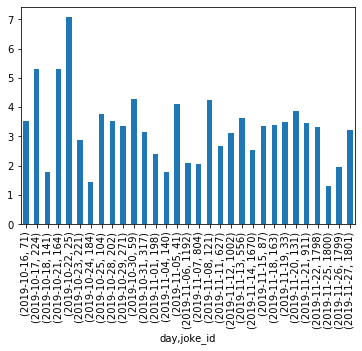

In [18]:
df_ratings.groupby(["day", "joke_id"])["rating"].std().plot.bar(x="day", y="rating")